In [1]:
!pip install tensorflow pillow matplotlib

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
import os


In [3]:
# # Function to load and preprocess the images
# def load_and_preprocess_image(filepath):
#     image = Image.open(filepath).convert('L')  # Convert to grayscale
#     image = image.resize((299, 299))  # Resize to 299x299 as required by InceptionV3
#     image = np.array(image)
#     image = np.stack((image,) * 3, axis=-1)  # Convert to 3 channels
#     image = preprocess_input(image)
#     return image


In [4]:
# # Load and preprocess all images in a directory
# def load_dataset(directory):
#     images = []
#     labels = []
#     for filename in os.listdir(directory):
#         if filename.endswith('.tif'):
#             filepath = os.path.join(directory, filename)
#             image = load_and_preprocess_image(filepath)
#             images.append(image)
#             # Assuming the filename format is 'flood_001.tif' or 'nonflood_001.tif'
#             label = 1 if 'flood' in filename.lower() else 0
#             labels.append(label)
#     images = np.array(images)
#     labels = np.array(labels)
#     labels = tf.keras.utils.to_categorical(labels, num_classes=2)
#     return images, labels

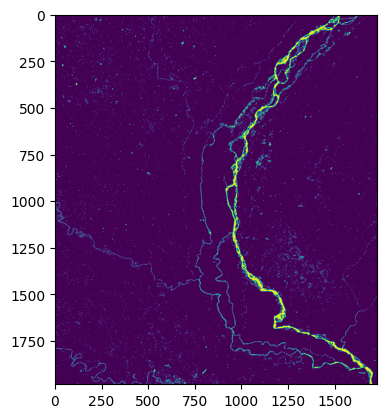

Image format: TIFF


In [5]:
# Attempt to open and display the problematic image
from PIL import Image
import matplotlib.pyplot as plt

try:
    img = Image.open('/content/drive/MyDrive/kosi_non_flood_new/water_satellite_2019-04-12.tif')
    plt.imshow(img)
    plt.show()
    print("Image format:", img.format)  # Print the detected image format
except Exception as e:
    print("Error opening image:", e)

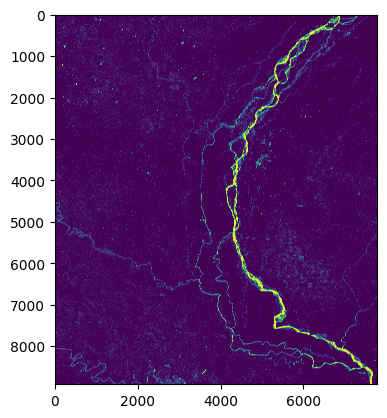

Image format: TIFF


In [6]:
# Attempt to open and display the problematic image
from PIL import Image
import matplotlib.pyplot as plt

try:
    img = Image.open('/content/drive/MyDrive/Kosi_Non_Flood/Water_satellite_new_2019-04-12.tif')
    plt.imshow(img)
    plt.show()
    print("Image format:", img.format)  # Print the detected image format
except Exception as e:
    print("Error opening image:", e)

In [7]:
# Attempt to open and display the problematic image
from PIL import Image
import matplotlib.pyplot as plt

try:
    img = Image.open('/content/drive/MyDrive/Inception v3_Flood/Kosi_flood_2019-09-22_2019_Ground_img.tif')
    plt.imshow(img)
    plt.show()
    print("Image format:", img.format)  # Print the detected image format
except Exception as e:
    print("Error opening image:", e)

Error opening image: [Errno 2] No such file or directory: '/content/drive/MyDrive/Inception v3_Flood/Kosi_flood_2019-09-22_2019_Ground_img.tif'


In [8]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 8.6 MB/s eta 0:00:00


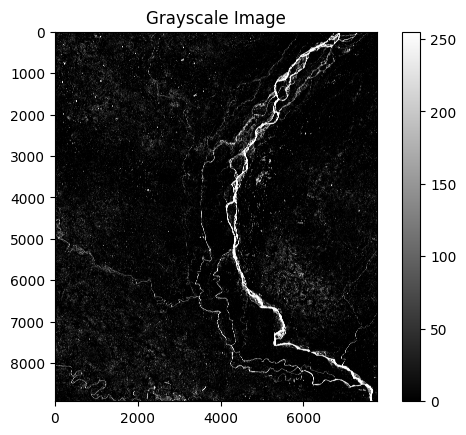

In [9]:
import matplotlib.pyplot as plt
import rasterio

# Load your .tif image
image_path = '/content/drive/MyDrive/Kosi_Non_Flood/WaterLevel_grayscale_2019-04-12.tif'
image = rasterio.open(image_path).read(1)

# Display the image in grayscale

plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Grayscale Image')
plt.show()


In [10]:
# Function to load and preprocess the images
def load_and_preprocess_image(filepath):
    try:
        image = Image.open(filepath).convert('L')  # Convert to grayscale
        image = image.resize((299, 299))  # Resize to 299x299 as required by InceptionV3
        image = np.array(image)
        image = np.stack((image,) * 3, axis=-1)  # Convert to 3 channels
        image = preprocess_input(image)
        return image
    except UnidentifiedImageError:
        print(f"Warning: Could not open {filepath}. Skipping.")
        return None  # Return None for skipped images

# Load and preprocess all images in a directory
def load_dataset(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.tif'):
            filepath = os.path.join(directory, filename)
            image = load_and_preprocess_image(filepath)
            if image is not None:  # Check if image was loaded successfully
                images.append(image)
                # Assuming the filename format is 'flood_001.tif' or 'nonflood_001.tif'
                label = 1 if 'flood' in filename.lower() else 0
                labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    labels = tf.keras.utils.to_categorical(labels, num_classes=2)
    return images, labels

In [11]:
# Load train and validation datasets
train_images, train_labels = load_dataset('/content/drive/MyDrive/extra_ViT/train')
val_images, val_labels = load_dataset('/content/drive/MyDrive/extra_ViT/valid')

# Check lengths
print("Number of training images:", len(train_images))
print("Number of training labels:", len(train_labels))
print("Number of validation images:", len(val_images))
print("Number of validation labels:", len(val_labels))

Number of training images: 10
Number of training labels: 10
Number of validation images: 7
Number of validation labels: 7


In [12]:
print(train_images.shape)
print(train_labels.shape)
print(val_images.shape)
print(val_labels.shape)

(10, 299, 299, 3)
(10, 2)
(7, 299, 299, 3)
(7, 2)


In [13]:
print(train_labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [14]:
print(val_labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [15]:
# Load the Inception V3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


87910968/87910968 [==============================] - 1s 0us/step


In [16]:
# Train the model with frozen layers
model.fit(train_images, train_labels, epochs=3, batch_size=32, validation_data=(val_images, val_labels))

# Unfreeze the last few layers and fine-tune the model
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Re-compile the model
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
model.fit(train_images, train_labels, epochs=20, batch_size=32, validation_data=(val_images, val_labels))

Epoch 1/3
1/1 [==============================] - 12s 12s/step - loss: 0.6815 - accuracy: 0.7000 - val_loss: 0.4307 - val_accuracy: 1.0000
Epoch 2/3
1/1 [==============================] - 3s 3s/step - loss: 0.3877 - accuracy: 1.0000 - val_loss: 0.2454 - val_accuracy: 1.0000
Epoch 3/3
1/1 [==============================] - 3s 3s/step - loss: 0.2335 - accuracy: 1.0000 - val_loss: 0.1577 - val_accuracy: 1.0000
Epoch 1/20
1/1 [==============================] - 13s 13s/step - loss: 0.8168 - accuracy: 0.3000 - val_loss: 0.1532 - val_accuracy: 1.0000
Epoch 2/20
1/1 [==============================] - 4s 4s/step - loss: 0.6959 - accuracy: 0.3000 - val_loss: 0.1490 - val_accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 5s 5s/step - loss: 0.5898 - accuracy: 0.4000 - val_loss: 0.1449 - val_accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 4s 4s/step - loss: 0.4979 - accuracy: 0.7000 - val_loss: 0.1410 - val_accuracy: 1.0000
Epoch 5/20
1/1 [========================

In [17]:
# Evaluate the model
loss, accuracy = model.evaluate(val_images, val_labels)
print(f"Loss: {loss}, Accuracy: {accuracy}")


1/1 [==============================] - 2s 2s/step - loss: 0.0937 - accuracy: 1.0000
Loss: 0.09371348470449448, Accuracy: 1.0


In [ ]:
# Function to predict and display the result for a new image
def predict_new_image(url):
    image = load_and_preprocess_image(url)
    if image is None:
        print("Error: Failed to load or preprocess image.")
        return
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)
    print("Predictions:", prediction)
    plt.imshow(Image.open(url).convert('L'), cmap='gray')
    plt.title('Flood' if np.argmax(prediction) == 1 else 'Non-flood')
    plt.show()


1/1 [==============================] - 2s 2s/step
Predictions: [[0.0811001  0.91889995]]


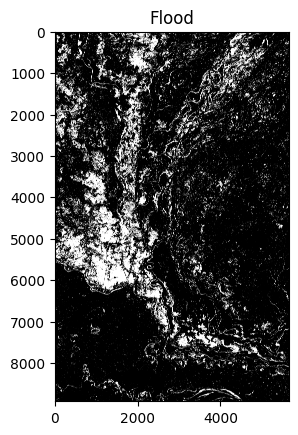

In [ ]:
# predicting new image
predict_new_image('/content/drive/MyDrive/sample dataset/valid/images/2.tif')

1/1 [==============================] - 0s 343ms/step
Predictions: [[0.06725024 0.9327498 ]]


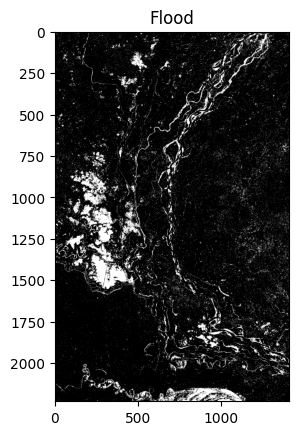

In [ ]:
predict_new_image('/content/drive/MyDrive/Inception v3_Flood/Kosi_flood_2019-09-27_2019_Ground_img.tif')

1/1 [==============================] - 0s 229ms/step
Predictions: [[0.9671773  0.03282268]]


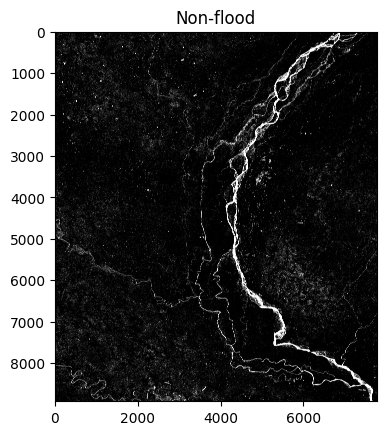

In [ ]:
predict_new_image('/content/drive/MyDrive/Kosi_Non_Flood/WaterLevel_grayscale_2019-04-12.tif')